In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '65-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [16]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 128,
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 128,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-00a03a913a177ffd710f19e39a9e65d51860d02557f57cc1d1d8e589'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

In [11]:
#@title
lr_min = 1e-6
# lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
# hold_max_steps = 0
# step_decay = .8
# step_size = steps_per_epoch * 1

# rng = [i for i in range(0, total_steps, 32)]
# y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
#                                warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
#                                lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

# sns.set(style="whitegrid")
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [12]:
#@title
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [13]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [17]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Resample dataframe
k_fold = k_fold[k_fold['image_name'].isin(image_names)]

# Test
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))

test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_auc', mode='max', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            optimizer = tfa.optimizers.RectifiedAdam(lr=lr_max,
                                                     total_steps=total_steps,
                                                     warmup_proportion=(warmup_steps / total_steps),
                                                     min_lr=lr_min)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.2), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es],
                            class_weight=class_weight, 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Last model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds_last += model.predict(test_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Best model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds += model.predict(test_image_data)


# normalize preds
test_preds /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.59.153.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.153.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 39s - loss: 2.0332 - auc: 0.5743 - val_loss: 0.4995 - val_auc: 0.6436
Epoch 2/12
204/204 - 25s - loss: 1.1337 - auc: 0.7485 - val_loss: 0.4872 - val_auc: 0.8500
Epoch 3/12
204/204 - 26s - loss: 0.5846 - auc: 0.8467 - val_loss: 0.4680 - val_auc: 0.8624
Epoch 4/12
204/204 - 26s - loss: 0.5583 - auc: 0.8660 - val_loss: 0.4920 - val_auc: 0.8686
Epoch 5/12
204/204 - 26s - loss: 0.5395 - auc: 0.8806 - val_loss: 0.5343 - val_auc: 0.8811
Epoch 6/12
204/204 - 24s - loss: 0.5344 - auc: 0.8904 - val_loss: 0.5448 - val_auc: 0.8747
Epoch 7/12
204/204 - 26s - loss: 0.5066 - auc: 0.9135 - val_loss: 0.4677 - val_auc: 0.8878
Epoch 8/12
204/204 - 26s - loss: 0.5029 - auc: 0.9231 - val_loss: 0.5137 - val_auc: 0.8948
Epoch 9/12
204/204 - 24s - loss: 0.4839 - auc: 0.9337 - val_loss: 0.4823 - val_auc: 0.8936
Epoch 10/12
204/204 - 24s - loss: 0.4767 - auc: 0.9390 - val_loss: 0.4538 - val_auc: 0.8923
Epoch 11/12
204/204 - 26s - loss: 0.4745 - auc: 0.9434 - val_loss: 0.4545 - val_auc: 0.89

INFO:tensorflow:Initializing the TPU system: grpc://10.59.153.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.153.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 39s - loss: 2.0835 - auc: 0.5726 - val_loss: 0.4961 - val_auc: 0.6249
Epoch 2/12
204/204 - 26s - loss: 1.1475 - auc: 0.7196 - val_loss: 0.5214 - val_auc: 0.8333
Epoch 3/12
204/204 - 26s - loss: 0.5964 - auc: 0.8321 - val_loss: 0.4775 - val_auc: 0.8708
Epoch 4/12
204/204 - 26s - loss: 0.5574 - auc: 0.8566 - val_loss: 0.5010 - val_auc: 0.8709
Epoch 5/12
204/204 - 26s - loss: 0.5478 - auc: 0.8746 - val_loss: 0.4665 - val_auc: 0.8758
Epoch 6/12
204/204 - 26s - loss: 0.5383 - auc: 0.8854 - val_loss: 0.5519 - val_auc: 0.8998
Epoch 7/12
204/204 - 24s - loss: 0.5266 - auc: 0.9005 - val_loss: 0.4979 - val_auc: 0.8889
Epoch 8/12
204/204 - 26s - loss: 0.5020 - auc: 0.9172 - val_loss: 0.4603 - val_auc: 0.9035
Epoch 9/12
204/204 - 24s - loss: 0.4916 - auc: 0.9322 - val_loss: 0.4763 - val_auc: 0.8969
Epoch 10/12
204/204 - 26s - loss: 0.4802 - auc: 0.9359 - val_loss: 0.4964 - val_auc: 0.9068
Epoch 11/12
204/204 - 24s - loss: 0.4722 - auc: 0.9454 - val_loss: 0.4826 - val_auc: 0.90

INFO:tensorflow:Initializing the TPU system: grpc://10.59.153.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.153.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 39s - loss: 1.9041 - auc: 0.5892 - val_loss: 0.4799 - val_auc: 0.6897
Epoch 2/12
204/204 - 26s - loss: 1.0489 - auc: 0.7476 - val_loss: 0.4952 - val_auc: 0.8475
Epoch 3/12
204/204 - 26s - loss: 0.5876 - auc: 0.8449 - val_loss: 0.5411 - val_auc: 0.8596
Epoch 4/12
204/204 - 26s - loss: 0.5558 - auc: 0.8660 - val_loss: 0.5219 - val_auc: 0.8935
Epoch 5/12
204/204 - 25s - loss: 0.5320 - auc: 0.8863 - val_loss: 0.4846 - val_auc: 0.8931
Epoch 6/12
204/204 - 25s - loss: 0.5325 - auc: 0.8930 - val_loss: 0.4818 - val_auc: 0.8924
Epoch 7/12
204/204 - 27s - loss: 0.5227 - auc: 0.8990 - val_loss: 0.5553 - val_auc: 0.8951
Epoch 8/12
204/204 - 27s - loss: 0.4984 - auc: 0.9238 - val_loss: 0.4640 - val_auc: 0.8986
Epoch 9/12
204/204 - 24s - loss: 0.4854 - auc: 0.9355 - val_loss: 0.4976 - val_auc: 0.8900
Epoch 10/12
204/204 - 25s - loss: 0.4809 - auc: 0.9364 - val_loss: 0.4636 - val_auc: 0.8933
Epoch 11/12
204/204 - 26s - loss: 0.4678 - auc: 0.9465 - val_loss: 0.4751 - val_auc: 0.90

INFO:tensorflow:Initializing the TPU system: grpc://10.59.153.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.153.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 39s - loss: 2.0184 - auc: 0.5951 - val_loss: 0.4984 - val_auc: 0.6398
Epoch 2/12
204/204 - 27s - loss: 1.1827 - auc: 0.7357 - val_loss: 0.4849 - val_auc: 0.8593
Epoch 3/12
204/204 - 26s - loss: 0.5888 - auc: 0.8468 - val_loss: 0.5042 - val_auc: 0.8869
Epoch 4/12
204/204 - 25s - loss: 0.5608 - auc: 0.8586 - val_loss: 0.4972 - val_auc: 0.8841
Epoch 5/12
204/204 - 27s - loss: 0.5438 - auc: 0.8743 - val_loss: 0.4910 - val_auc: 0.8922
Epoch 6/12
204/204 - 27s - loss: 0.5327 - auc: 0.8879 - val_loss: 0.4516 - val_auc: 0.9031
Epoch 7/12
204/204 - 25s - loss: 0.5189 - auc: 0.9073 - val_loss: 0.5042 - val_auc: 0.8989
Epoch 8/12
204/204 - 27s - loss: 0.5031 - auc: 0.9169 - val_loss: 0.5070 - val_auc: 0.9194
Epoch 9/12
204/204 - 27s - loss: 0.4966 - auc: 0.9251 - val_loss: 0.4869 - val_auc: 0.9216
Epoch 10/12
204/204 - 25s - loss: 0.4794 - auc: 0.9402 - val_loss: 0.4853 - val_auc: 0.9216
Epoch 11/12
204/204 - 27s - loss: 0.4640 - auc: 0.9484 - val_loss: 0.4730 - val_auc: 0.92

INFO:tensorflow:Initializing the TPU system: grpc://10.59.153.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.153.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 38s - loss: 1.9376 - auc: 0.5733 - val_loss: 0.4981 - val_auc: 0.6171
Epoch 2/12
204/204 - 26s - loss: 1.1102 - auc: 0.7453 - val_loss: 0.5156 - val_auc: 0.8456
Epoch 3/12
204/204 - 27s - loss: 0.5991 - auc: 0.8354 - val_loss: 0.5075 - val_auc: 0.8517
Epoch 4/12
204/204 - 27s - loss: 0.5581 - auc: 0.8656 - val_loss: 0.4555 - val_auc: 0.8690
Epoch 5/12
204/204 - 25s - loss: 0.5421 - auc: 0.8764 - val_loss: 0.5057 - val_auc: 0.8651
Epoch 6/12
204/204 - 27s - loss: 0.5342 - auc: 0.8913 - val_loss: 0.4967 - val_auc: 0.8746
Epoch 7/12
204/204 - 27s - loss: 0.5201 - auc: 0.9057 - val_loss: 0.4579 - val_auc: 0.8902
Epoch 8/12
204/204 - 25s - loss: 0.5083 - auc: 0.9161 - val_loss: 0.4905 - val_auc: 0.8885
Epoch 9/12
204/204 - 26s - loss: 0.4936 - auc: 0.9272 - val_loss: 0.5179 - val_auc: 0.8952
Epoch 10/12
204/204 - 24s - loss: 0.4778 - auc: 0.9383 - val_loss: 0.4568 - val_auc: 0.8820
Epoch 11/12
204/204 - 25s - loss: 0.4756 - auc: 0.9486 - val_loss: 0.4795 - val_auc: 0.89

## Model loss graph

Fold: 1


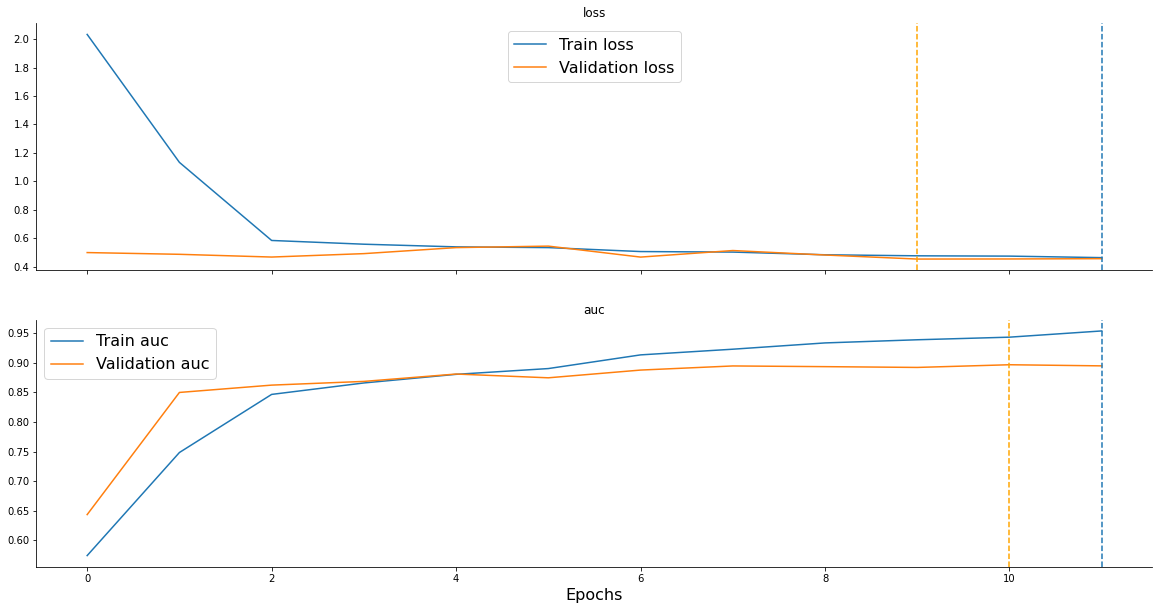

Fold: 2


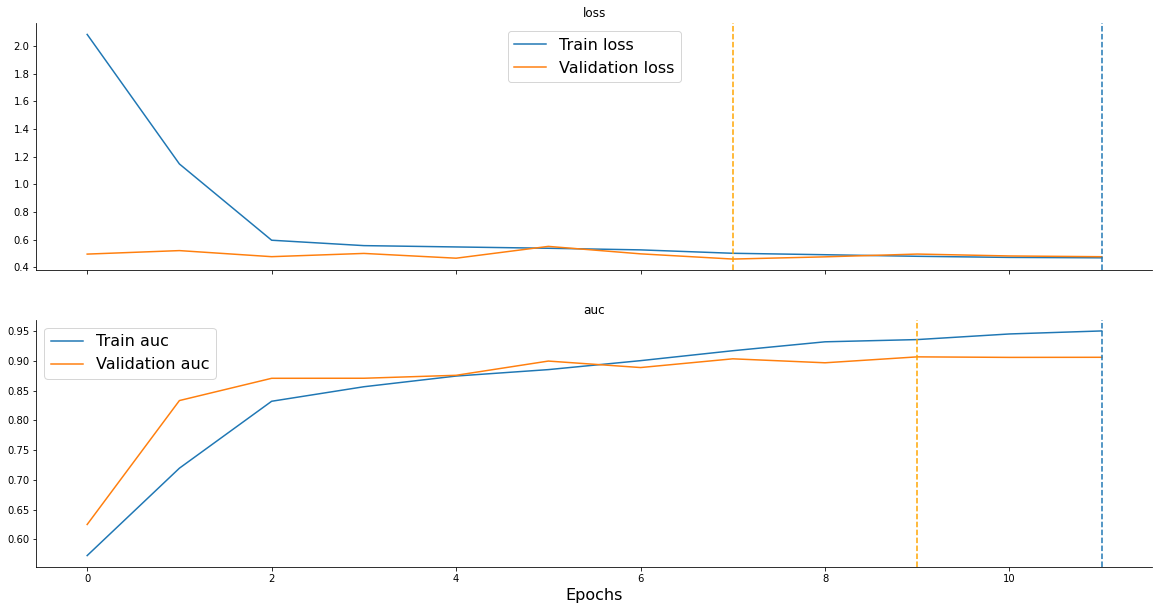

Fold: 3


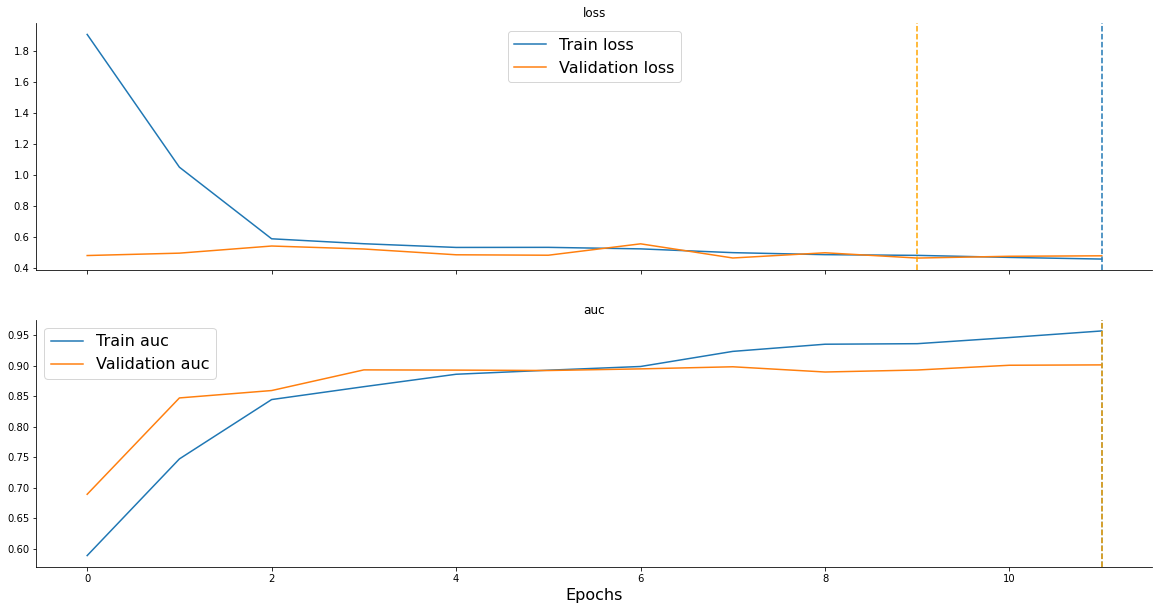

Fold: 4


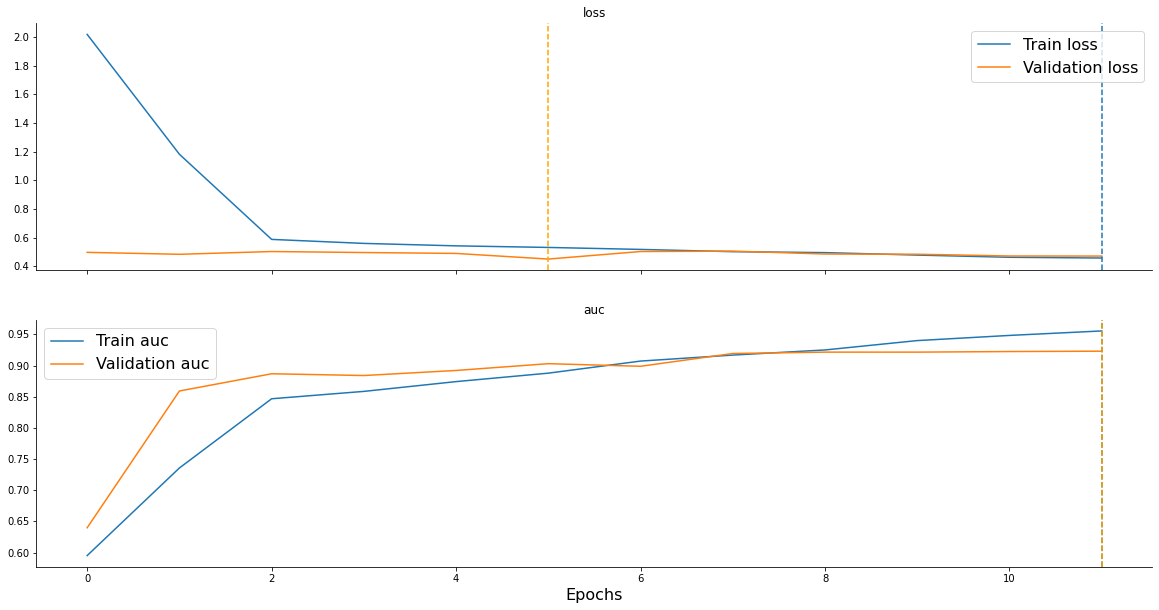

Fold: 5


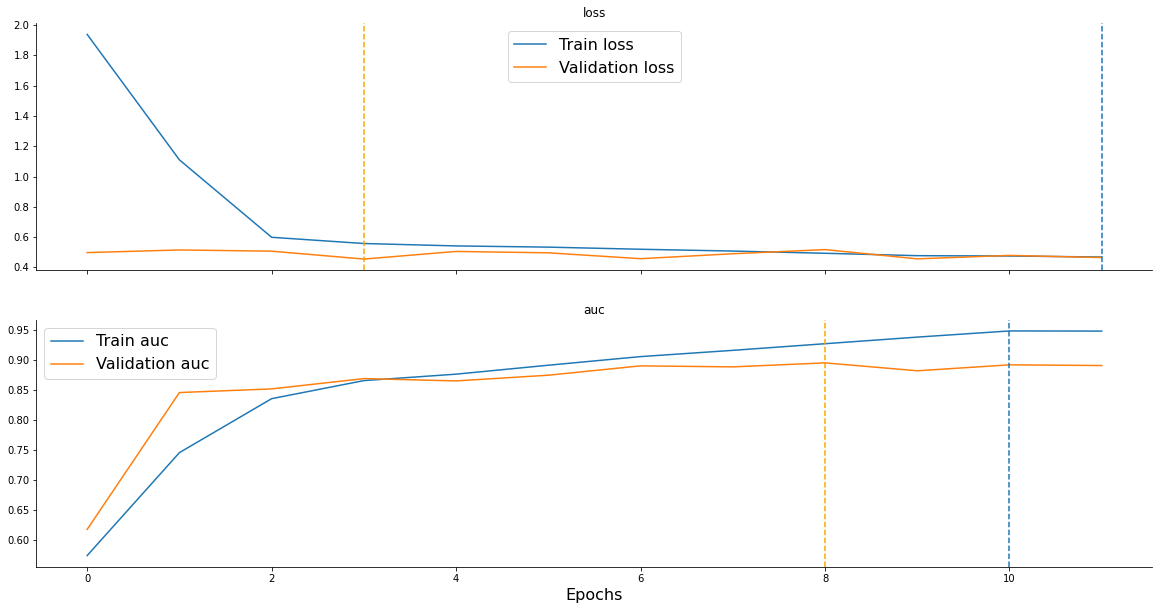

In [18]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

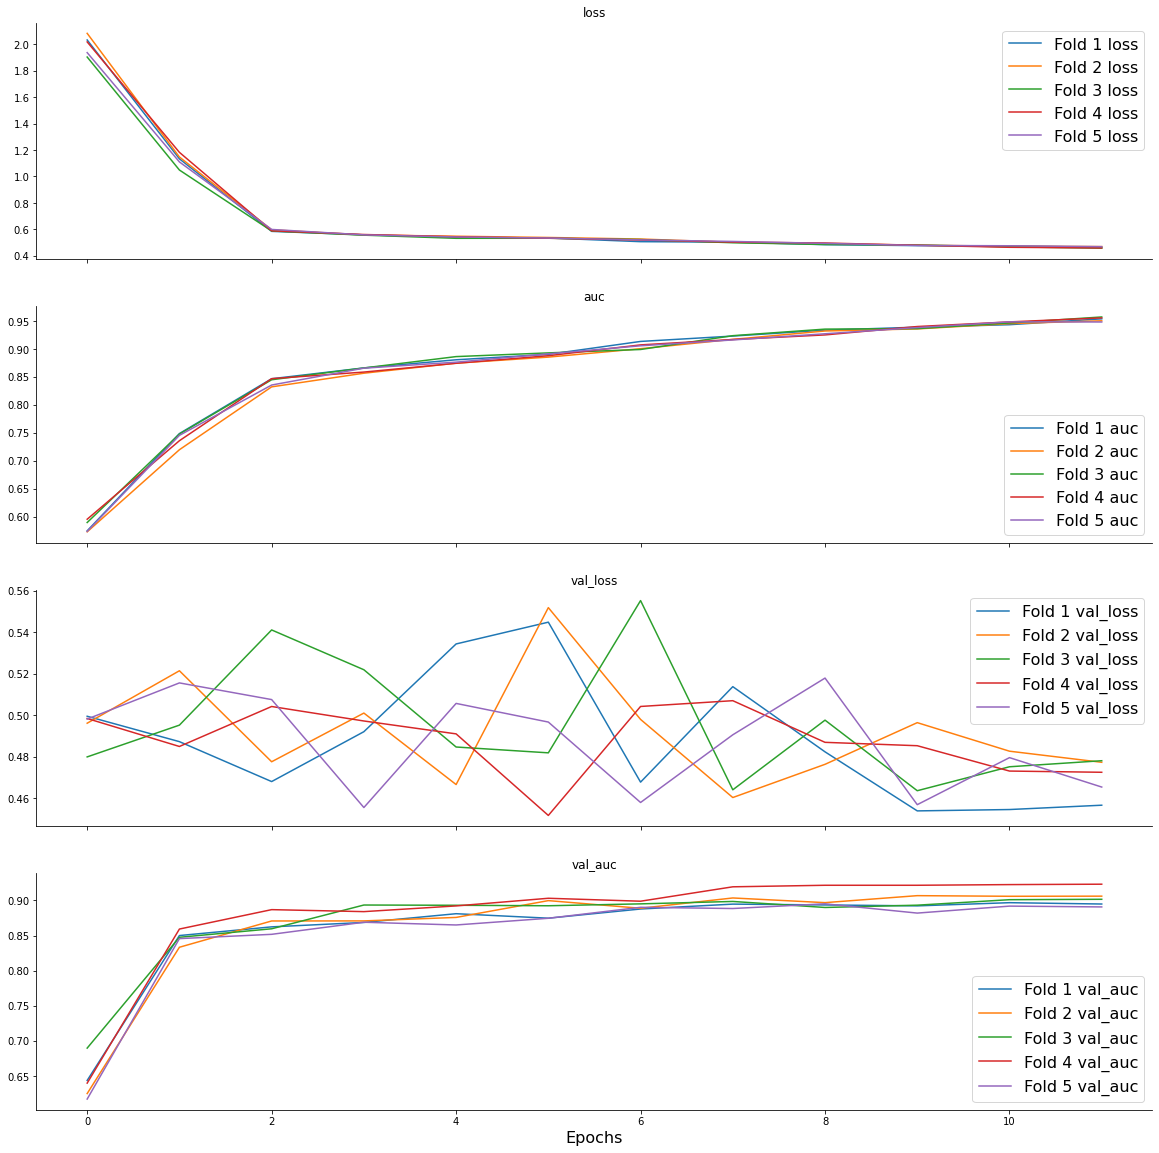

In [19]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (best)

In [20]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.979056,0.904889,0.074167,0.981149,0.896737,0.977389,0.907057,0.981197,0.902424,0.982482,0.923274,0.973062,0.894952
Accuracy,0.870249,0.861254,0.008995,0.885834,0.885268,0.864708,0.847216,0.882551,0.866321,0.887309,0.873699,0.830840,0.833766
Precision,0.120908,0.094200,0.026708,0.133721,0.099622,0.113762,0.090317,0.129197,0.091496,0.134021,0.109392,0.093840,0.080172
Recall,0.980635,0.779468,0.201167,0.987124,0.686957,0.974194,0.836207,0.978448,0.726496,0.982721,0.838983,0.980687,0.808696
F1-score,0.214937,0.167798,0.047140,0.235535,0.174009,0.203733,0.163025,0.228255,0.162524,0.235874,0.193548,0.171289,0.145882
Support,464.800000,116.200000,348.600000,466.000000,115.000000,465.000000,116.000000,464.000000,117.000000,463.000000,118.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.979056,0.904889,0.074167,0.981149,0.896737,0.977389,0.907057,0.981197,0.902424,0.982482,0.923274,0.973062,0.894952
male,0.979729,0.906211,0.073518,0.981334,0.903307,0.976674,0.897540,0.983436,0.887288,0.982352,0.930289,0.974851,0.912631
female,0.977169,0.897571,0.079598,0.980577,0.878766,0.977436,0.915333,0.976875,0.916510,0.981766,0.912195,0.969191,0.865051
head/neck,0.957456,0.873608,0.083848,0.966960,0.822940,0.949094,0.889504,0.963170,0.879586,0.960451,0.881286,0.947606,0.894726
upper extremity,0.977966,0.907282,0.070684,0.981508,0.897004,0.975413,0.909568,0.980362,0.924148,0.981238,0.934941,0.971309,0.870747
lower extremity,0.980095,0.878343,0.101752,0.980248,0.875434,0.977001,0.885064,0.985225,0.881181,0.985185,0.869033,0.972815,0.881003
torso,0.981214,0.919067,0.062147,0.982959,0.913814,0.980955,0.913136,0.981309,0.905472,0.984260,0.952352,0.976589,0.910561
0 <= age < 26,0.971605,0.825331,0.146274,0.972170,0.997085,0.959821,0.838574,0.972869,0.881291,0.978284,0.483193,0.974879,0.926511
26 <= age < 40,0.986114,0.904462,0.081653,0.989366,0.919850,0.985306,0.938123,0.988441,0.911492,0.991211,0.922222,0.976248,0.830620


# Model evaluation (last)

In [21]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.981365,0.903756,0.077608,0.980976,0.896238,0.980984,0.905326,0.981189,0.902021,0.982586,0.923829,0.981089,0.891366
Accuracy,0.884398,0.873423,0.010975,0.883043,0.884045,0.886486,0.867618,0.882513,0.865710,0.887156,0.871402,0.882789,0.878339
Precision,0.131246,0.100102,0.031144,0.130311,0.099626,0.132982,0.100535,0.129161,0.091104,0.133863,0.107609,0.129915,0.101636
Recall,0.979348,0.765600,0.213749,0.980687,0.695652,0.976344,0.810345,0.978448,0.726496,0.982721,0.838983,0.978541,0.756522
F1-score,0.231467,0.177004,0.054463,0.230053,0.174292,0.234081,0.178877,0.228198,0.161905,0.235629,0.190751,0.229376,0.179197
Support,464.800000,116.200000,348.600000,466.000000,115.000000,465.000000,116.000000,464.000000,117.000000,463.000000,118.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.981365,0.903756,0.077608,0.980976,0.896238,0.980984,0.905326,0.981189,0.902021,0.982586,0.923829,0.981089,0.891366
male,0.981901,0.905881,0.076019,0.981309,0.904188,0.980698,0.898801,0.983383,0.886932,0.982387,0.930776,0.981727,0.908708
female,0.979773,0.895128,0.084645,0.980102,0.876117,0.980528,0.907784,0.976949,0.916082,0.981915,0.912611,0.979373,0.863045
head/neck,0.963840,0.871246,0.092594,0.968274,0.818812,0.958568,0.893660,0.963059,0.879586,0.961453,0.881745,0.967846,0.882427
upper extremity,0.980260,0.906937,0.073323,0.981254,0.896483,0.978891,0.915346,0.980486,0.924865,0.981372,0.935728,0.979300,0.862265
lower extremity,0.982602,0.875298,0.107304,0.979983,0.875529,0.982644,0.872255,0.985087,0.880165,0.985458,0.869863,0.979839,0.878679
torso,0.983123,0.918247,0.064876,0.982835,0.912657,0.983200,0.910967,0.981363,0.904782,0.984275,0.952532,0.983943,0.910297
0 <= age < 26,0.975951,0.826274,0.149677,0.972917,0.997085,0.973712,0.823550,0.972585,0.882475,0.978190,0.495798,0.982353,0.932463
26 <= age < 40,0.989423,0.900767,0.088656,0.989560,0.918665,0.989018,0.935934,0.988942,0.911895,0.991281,0.922498,0.988314,0.814843


# Confusion matrix

Fold: 1


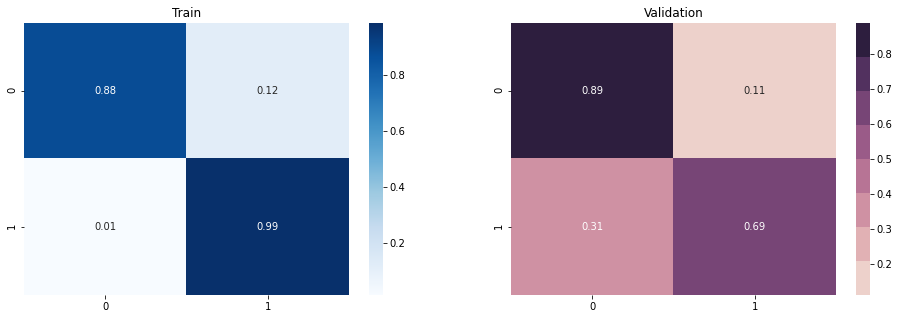

Fold: 2


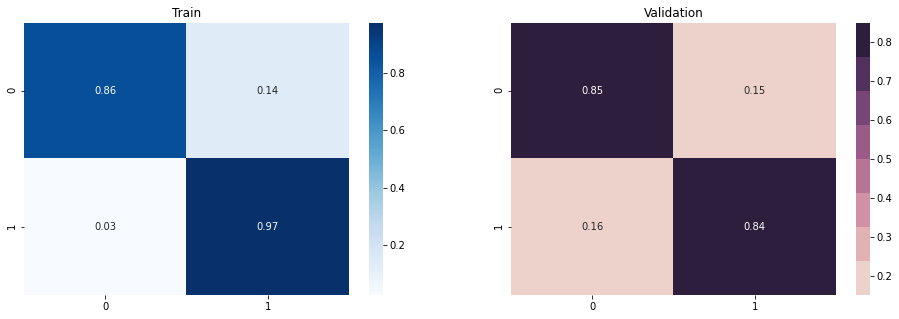

Fold: 3


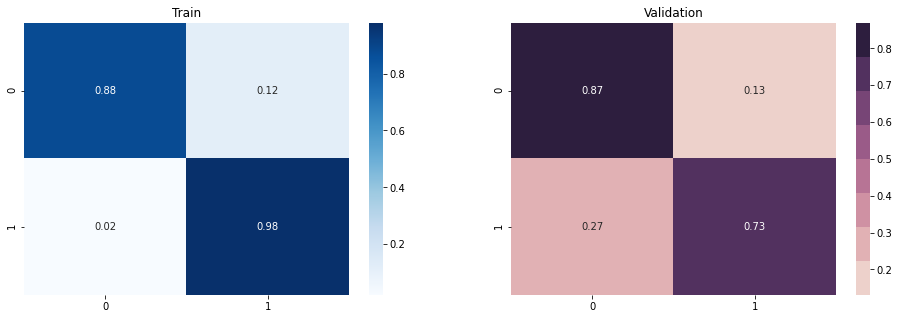

Fold: 4


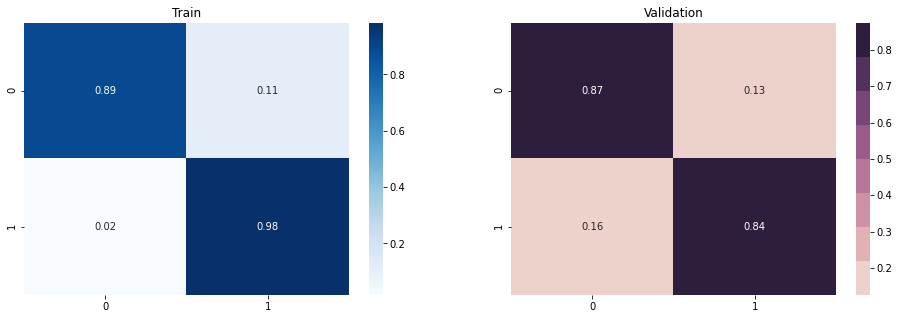

Fold: 5


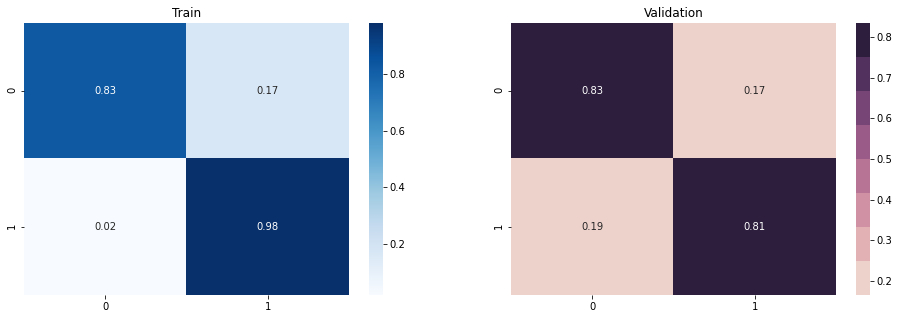

In [22]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [23]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 581
Train positive predictions: 4164
Train positive correct predictions: 573
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.310377,0.399250,0.262838,0.343187,0.223983,0.322626
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.055202,0.051445,0.050068,0.065427,0.061566,0.047504
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.060937,0.044447,0.077600,0.054751,0.064171,0.063715
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.224396,0.144117,0.205830,0.193981,0.424720,0.153332
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.054000,0.059189,0.054892,0.045700,0.048427,0.061791
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.125080,0.097238,0.167840,0.068685,0.106422,0.185214
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.139003,0.281973,0.097103,0.084064,0.083194,0.148678
7,ISIC_0075663,female,35.0,torso,unknown,0,0.305121,0.589009,0.104223,0.189632,0.228156,0.414587
8,ISIC_0075914,male,30.0,torso,unknown,0,0.143277,0.203568,0.094688,0.143867,0.179189,0.095074
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.110942,0.092058,0.085308,0.147156,0.062236,0.167955


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.230789,0.263587,0.227789,0.426148,0.123545,0.112874
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.795361,0.845220,0.891431,0.864441,0.803866,0.571849
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.689047,0.915768,0.581809,0.675949,0.475188,0.796521
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.667713,0.715300,0.386329,0.783695,0.519446,0.933793
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.717500,0.773252,0.816978,0.443978,0.837419,0.715873
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.881026,0.921149,0.881425,0.903863,0.782421,0.916271
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.901947,0.976324,0.613261,0.956035,0.971492,0.992622
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.823817,0.905441,0.918688,0.846949,0.916562,0.531446
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.764722,0.772341,0.803386,0.777481,0.799708,0.670696
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.868953,0.835427,0.708614,0.900488,0.955141,0.945096


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
10,ISIC_0076545,male,55.0,upper extremity,unknown,0,0.762726,0.735268,0.853973,0.847754,0.711303,0.665331
20,ISIC_0080817,male,50.0,lower extremity,unknown,0,0.512569,0.536210,0.730554,0.279176,0.528890,0.488015
48,ISIC_0092870,male,55.0,torso,unknown,0,0.649679,0.733096,0.526740,0.595659,0.707644,0.685255
76,ISIC_0120729,male,65.0,lower extremity,unknown,0,0.510192,0.493350,0.552529,0.578318,0.483307,0.443456
95,ISIC_0150975,female,50.0,lower extremity,unknown,0,0.543915,0.489365,0.488016,0.672314,0.580683,0.489196
111,ISIC_0155012,male,55.0,torso,nevus,0,0.596596,0.632788,0.619929,0.429538,0.639148,0.661576
117,ISIC_0156642,female,40.0,torso,nevus,0,0.657230,0.685352,0.571029,0.604489,0.708580,0.716701
123,ISIC_0159060,male,55.0,head/neck,unknown,0,0.713547,0.808458,0.616595,0.711211,0.691173,0.740297
128,ISIC_0159996,female,60.0,head/neck,unknown,0,0.794496,0.836823,0.790312,0.777335,0.719169,0.848842
131,ISIC_0160455,male,75.0,lower extremity,nevus,0,0.655008,0.663413,0.763971,0.481965,0.673941,0.691752


# Visualize test predictions

In [26]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 1784|9198
Test predictions (last) 1624|9358
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
0,ISIC_0052060,male,70.0,NaN,0.089483,0.092522
1,ISIC_0052349,male,40.0,lower extremity,0.059371,0.058182
2,ISIC_0058510,female,55.0,torso,0.065573,0.062929
3,ISIC_0073313,female,50.0,torso,0.066228,0.064770
4,ISIC_0073502,female,45.0,lower extremity,0.257444,0.223124
5,ISIC_0074618,male,50.0,lower extremity,0.194914,0.182006
6,ISIC_0076801,male,45.0,upper extremity,0.302652,0.284051
7,ISIC_0077586,male,50.0,lower extremity,0.423764,0.359576
8,ISIC_0082004,female,45.0,torso,0.286811,0.238546
9,ISIC_0082785,male,65.0,lower extremity,0.180206,0.162476


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
19,ISIC_0099348,female,45.0,upper extremity,0.635395,0.612556
24,ISIC_0112420,female,65.0,torso,0.818004,0.819201
41,ISIC_0155813,male,55.0,lower extremity,0.500796,0.476657
42,ISIC_0155983,male,70.0,torso,0.847763,0.827931
45,ISIC_0161963,male,35.0,upper extremity,0.630654,0.591176
56,ISIC_0169906,male,85.0,torso,0.764177,0.716852
57,ISIC_0171865,male,65.0,palms/soles,0.703391,0.688391
61,ISIC_0175798,female,55.0,torso,0.789343,0.770841
64,ISIC_0178235,female,70.0,lower extremity,0.715927,0.646152
67,ISIC_0178741,female,70.0,upper extremity,0.505143,0.485533


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
19,ISIC_0099348,female,45.0,upper extremity,0.635395,0.612556
24,ISIC_0112420,female,65.0,torso,0.818004,0.819201
42,ISIC_0155983,male,70.0,torso,0.847763,0.827931
45,ISIC_0161963,male,35.0,upper extremity,0.630654,0.591176
56,ISIC_0169906,male,85.0,torso,0.764177,0.716852
57,ISIC_0171865,male,65.0,palms/soles,0.703391,0.688391
61,ISIC_0175798,female,55.0,torso,0.789343,0.770841
64,ISIC_0178235,female,70.0,lower extremity,0.715927,0.646152
69,ISIC_0182213,female,80.0,head/neck,0.779344,0.779653
71,ISIC_0183449,female,60.0,lower extremity,0.817863,0.801164


# Test set predictions

In [28]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend
0,ISIC_0052060,0.089483,0.092522,0.091002
1,ISIC_0052349,0.059371,0.058182,0.058777
2,ISIC_0058510,0.065573,0.062929,0.064251
3,ISIC_0073313,0.066228,0.064770,0.065499
4,ISIC_0073502,0.257444,0.223124,0.240284
5,ISIC_0074618,0.194914,0.182006,0.188460
6,ISIC_0076801,0.302652,0.284051,0.293351
7,ISIC_0077586,0.423764,0.359576,0.391670
8,ISIC_0082004,0.286811,0.238546,0.262679
9,ISIC_0082785,0.180206,0.162476,0.171341


,target,target_last,target_blend
count,10982.000000,10982.000000,10982.000000
mean,0.262802,0.251216,0.257009
std,0.212824,0.207258,0.209867
min,0.036387,0.035815,0.036687
25%,0.092377,0.089793,0.091311
50%,0.178201,0.165328,0.172022
75%,0.382655,0.359780,0.371338
max,0.956003,0.950807,0.952942
